# Задание 1. Поиск минимального значения в векторе
Необходимо найти минимальное значение среди элементов вектора. Для этого воспользуемся тремя подходами:
- Перебор значений в одном потоке
- Распараллеливание по данным в цикле: 
  - С обеспечением синхронизации за счет помещения операции сравнения элементов в критическую секцию
  - С использованием редукции оператором `min`

## Описание подходов
Все описанные алгоритмы находятся в модуле [`vectorMinValue`](../vectorMinValue/vectorMinValueImpl.c).

### Перебор значений в одном потоке
Реализация данного подхода содержится в методе `FindMinSingleThread`. Алгоритм предельно прост - сравниваем все элементы, пока не найдем среди них минимальный. 

```c 
int FindMinSingleThread(int *vector, int size) {
    int *end = vector + size;
    int min = INT_MAX;
    for (int *start = vector; start < end; start++) {
        if (min > *start) {
            min = *start;
        }
    }
    return min;
}
```

### Синхронизация за счет критической секции
Данный подход отличается от предыдущего наличием распараллеливания по данным в цикле. Чтобы обеспечить синхронизацию потоков, операция сравнения текущего элемента с текущим минимумом помещена в критическую секцию.

``` c
int FindMinWithForLoopParallelism(int *vector, int size) {
    int *end = vector + size;
    int min = INT_MAX;
#pragma omp parallel for shared(vector, end, min) default(none)
    for (int *start = vector; start < end; start++) {
        if (min > *start) {
#pragma omp critical
            if (min > *start) {
                min = *start;
            }
        }
    }
    return min;
}
```

### Редукция
Третий подход заключается в использовании операции редукции вместе с оператором [min](https://www.openmp.org/spec-html/5.0/openmpsu107.html). 
```c
int FindMinWithReduction(int *vector, int size) {
    int minValue;
    int start;
#pragma omp parallel for shared(vector, size) private(start) reduction(min: minValue) default(none)
    for (start = 0; start < size; start++) {
        minValue = vector[start];
    }
    return minValue;
}
```

## Сравнение эффективности алгоритмов
Для сравнения алгоритмов были произведены замеры времени их работы на массивах, состоящих из 10000, 10000000 и 100000000 элементов. Было проведено 30 экспериментов, их результаты сохранены в файле [output.csv](../build/output.csv). 
Первые 10 строк таблицы представлены ниже.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

dataset = pd.read_csv("output.csv", sep=';')
array_sizes = {100: "small", 100000: "medium", 100000000: "large"}
dataset = dataset.astype({'method': 'category',  'array_size': 'category'})
dataset['array_size'] = dataset['array_size'].replace(array_sizes)
print(dataset.head(10))


   num_threads            method array_size  elapsed_time
0            1            single      small        0.0004
1            2  critical_section      small        0.0451
2            2         reduction      small        0.0012
3            3  critical_section      small        0.0476
4            3         reduction      small        0.0009
5            4  critical_section      small        0.0378
6            4         reduction      small        0.0009
7            5  critical_section      small        0.0420
8            5         reduction      small        0.0010
9            6  critical_section      small        0.0359


Рассчитаем среднее время работы каждого из описанных подходов при каждом из имеющихся размеров массивов.

In [2]:
means_for_single_thread = dataset[dataset['method'] == 'single'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_critical_section = dataset[dataset['method'] == 'critical_section'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_reduction = dataset[dataset['method'] == 'reduction'][['array_size', 'elapsed_time']].groupby('array_size').agg({'elapsed_time': 'mean'}).sort_values('array_size')
means_for_reduction.head()

,elapsed_time
array_size,
small,0.311443
medium,0.331107
large,39.117230


In [3]:
def visualize(ylabel, title, data):
    labels = array_sizes.keys()
    x = np.arange(len(labels)) 
    width = 0.2 

    fig, ax = plt.subplots(figsize=(15,10))
    rects1 = ax.bar(x - 3*width/2, data['single'], width, label='Однопоточная версия')
    rects2 = ax.bar(x - width/2, data['critical_section'], width, label='Многопоточная с критической секцией')
    rects3 = ax.bar(x + width/2, data['reduction'], width, label='Многопоточная с редукцией')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlabel('Размер массива')
    ax.set_xticks(x, labels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.15f'))
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    fig.tight_layout()

Визуализируем данные. Построим гистограмму среднего времени работы каждого из подходов для каждого из доступных размеров массивов. 

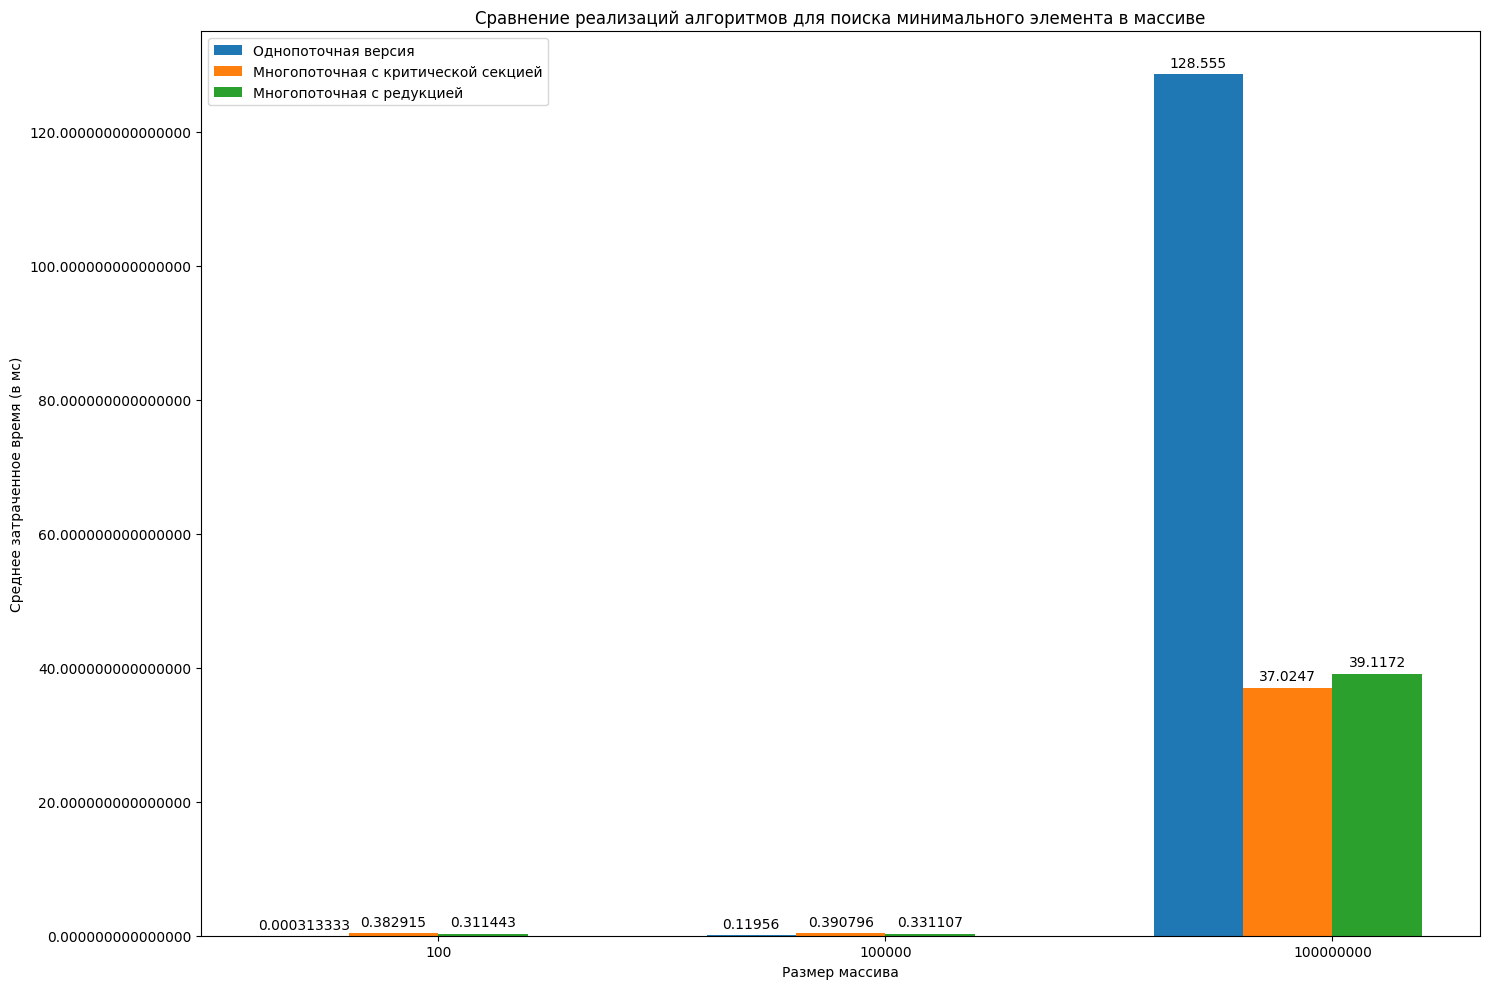

In [4]:
mean_data = dict(zip(dataset['method'].unique(), [
                means_for_single_thread['elapsed_time'], means_for_critical_section['elapsed_time'], means_for_reduction['elapsed_time']]))
visualize('Среднее затраченное время (в мс)', 'Сравнение реализаций алгоритмов для поиска минимального элемента в массиве', mean_data)


Легко заметить, что в среднем при использовании многопоточности скорость работы повышается примерно в 2 раза относительно однопоточной программы (за исключением массивов небольшого размера). Теперь построим график зависимости ускорения от количества использованных процессов.

In [5]:
means_for_single_thread = dataset[dataset['method'] == 'single'].groupby(
    'array_size').agg({'elapsed_time': 'mean'}).reset_index()

means_for_multhread = dataset[dataset['num_threads'] >= 2].groupby(
    ['num_threads', 'array_size', 'method']).agg({'elapsed_time': 'mean'})
means_for_multhread = means_for_multhread[means_for_multhread['elapsed_time'].notnull(
)].reset_index()


smtet = means_for_multhread[means_for_multhread['array_size']
                            == 'small']['elapsed_time']
sstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'small']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'small', 'boost'] = sstet.loc[0]/ smtet 

mmtet = means_for_multhread[means_for_multhread['array_size']
                            == 'medium']['elapsed_time']
mstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'medium']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'medium', 'boost'] = mstet.loc[1] / mmtet 

lmtet = means_for_multhread[means_for_multhread['array_size']
                            == 'large']['elapsed_time']
lstet = means_for_single_thread[means_for_single_thread['array_size']
                                == 'large']['elapsed_time']
means_for_multhread.loc[means_for_multhread['array_size']
                        == 'large', 'boost'] = lstet.loc[2] / lmtet 


In [6]:
def visualize_boost(data, filters, title):
    labels = dataset.num_threads.unique()[1:]
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 5))
    bfsa_critical = plt.plot(
        x, data.loc[filters['critical'], 'boost'], label='Критическая секция')
    bfsa_reduction = plt.plot(
        x, data.loc[filters['reduction'], 'boost'], label='Редукция')

    ax.set_xticks(x, labels)
    ax.set_title(title)
    ax.set_xlabel('Количество потоков')
    ax.set_ylabel('Ускорение')
    ax.grid()
    ax.legend()
        

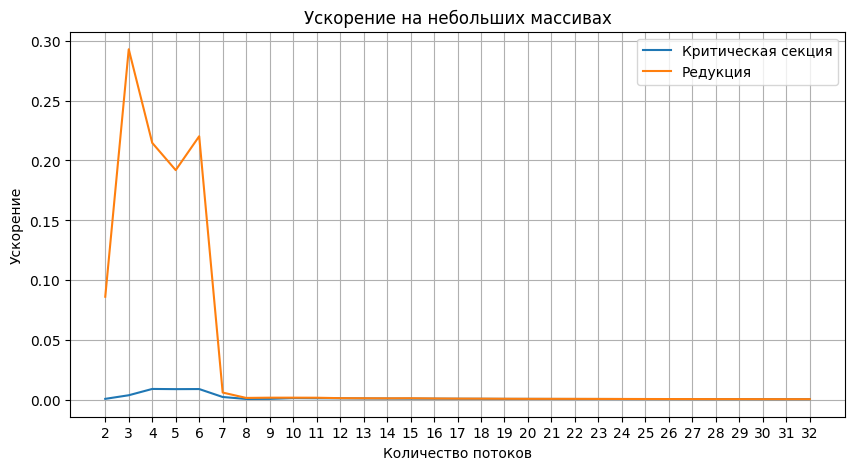

In [7]:
filters_for_small_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'small'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'small')
}
visualize_boost(means_for_multhread, filters_for_small_arrays, 'Ускорение на небольших массивах')

Как и ожидалось, на массивах небольшого размера обе многопоточные версии оказываются неэффективными.

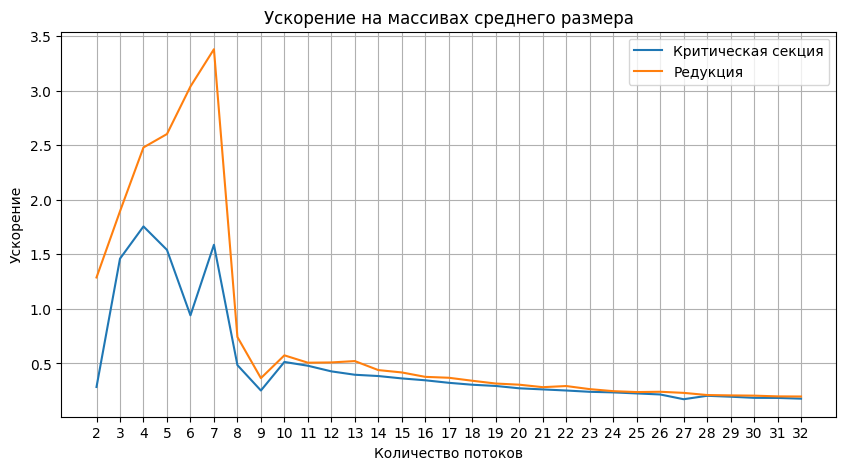

In [8]:
filters_for_medium_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'medium'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'medium')
}
visualize_boost(means_for_multhread, filters_for_medium_arrays, 'Ускорение на массивах среднего размера')

Для массивов среднего размера максимальное ускорение в 3 раза дает редукция при использовании 7 потоков. Алгоритм с критической секцией оказывается незначительно быстрее однопоточной версии при использовании 3-7 потоков. 

Для обоих алгоритмов, начиная с 8 потоков, при росте количества потоков ускорение стремится к 0.

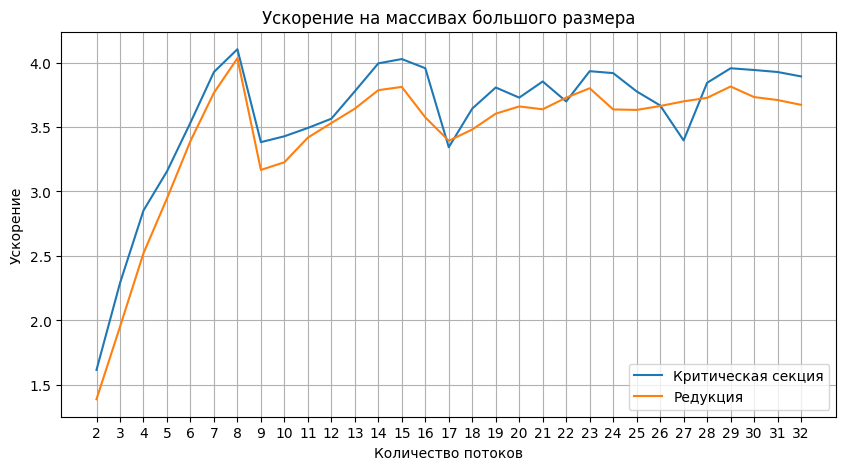

In [9]:
filters_for_large_arrays = {
    'critical': (means_for_multhread['method'] == 'critical_section') & (means_for_multhread['array_size'] == 'large'),
    'reduction': (means_for_multhread['method'] == 'reduction') & (means_for_multhread['array_size'] == 'large')
}
visualize_boost(means_for_multhread, filters_for_large_arrays, 'Ускорение на массивах большого размера')

Для больших массивов обе версии работают быстрее однопоточного алгоритма при любом количестве потоков. Максимальное ускорение в более чем 4 раза дает алгоритм с критической секцией при 8 потоках. Дальнейшее увеличение количества потоков не оказывает значительного влияния на ускорение.